In [1]:
import json
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from utils.config import load_config
from modules.models import RiemannianSpikeGNN
from manifolds import Lorentz, Sphere, Euclidean
from utils.data_utils import load_data
import warnings
from jupyterthemes import jtplot
jtplot.reset()
warnings.filterwarnings("ignore")

C:\Users\98311\Anaconda3\envs\torch10\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
json_path = "./configs/NC/computers/lorentz.json"
configs = load_config({}, json_path)
device = torch.device("cuda:0")
data = load_data(configs.root_path, configs.dataset)
if configs.manifold == "euclidean":
    manifold = Euclidean()
elif configs.manifold == 'lorentz':
    manifold = Lorentz()
elif configs.manifold == 'sphere':
    manifold = Sphere()
else:
    raise NotImplementedError
model = RiemannianSpikeGNN(manifold, T=configs.T, n_layers=configs.n_layers,
                                       in_dim=data["num_features"], neuron=configs.neuron,
                                       embed_dim=configs.embed_dim, n_classes=data["num_classes"],
                                       step_size=configs.step_size, v_threshold=configs.v_threshold,
                                       dropout=configs.dropout, self_train=configs.self_train,
                                       task=configs.task)
model.load_state_dict(torch.load(f"./checkpoints/{configs.task}_{configs.dataset}_{configs.manifold}_{0}.pt"))
model.eval()

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], train_mask=[13752], val_mask=[13752], test_mask=[13752])


RiemannianSpikeGNN(
  (manifold): Lorentz manifold
  (encoder): RSEncoderLayer(
    (manifold): Lorentz manifold
    (fc): GCNConv(767, 33)
    (drop): Dropout(p=0.1, inplace=False)
    (drop_edge): DropEdge()
    (neuron): RiemannianIFNode(
      (manifold): Lorentz manifold
    )
  )
  (layers): ModuleList(
    (0-1): 2 x RiemannianSGNNLayer(
      (manifold): Lorentz manifold
      (layer): GCNConv(33, 33)
      (neuron): RiemannianIFNode(
        (manifold): Lorentz manifold
      )
      (drop): Dropout(p=0.1, inplace=False)
      (drop_edge): DropEdge()
    )
  )
  (fc): Linear(in_features=33, out_features=10, bias=False)
)

In [3]:
from modules.neuron import RiemannianIFNode, RiemannianLIFNode
    
def remove_hooks(handles: list):
    for handle in handles:
        handle.remove()

In [4]:
grads_z = []
grads_v = []
def grad_hook(module, grad_input, grad_output):
    grads_z.append(grad_output[-1])
    grads_v.append(grad_input[2])

# back_hooks = []
# for name, module in model.named_modules():
#     if isinstance(module, RiemannianIFNode) or isinstance(module, RiemannianLIFNode):
#         bh = module.register_backward_hook(grad_hook)
#         back_hooks.append(bh)

In [5]:
from geoopt.optim import RiemannianAdam
from collections import defaultdict
data = load_data(configs.root_path, "computers")
model_to_train = RiemannianSpikeGNN(manifold, T=configs.T, n_layers=configs.n_layers,
                                       in_dim=data["num_features"], neuron=configs.neuron,
                                       embed_dim=configs.embed_dim, n_classes=data["num_classes"],
                                       step_size=configs.step_size, v_threshold=configs.v_threshold,
                                       dropout=configs.dropout, self_train=configs.self_train,
                                       task=configs.task).to(device)
def send_deive(d, device):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = v.to(device)
            
back_hooks = []
for name, module in model_to_train.named_modules():
    if isinstance(module, RiemannianIFNode) or isinstance(module, RiemannianLIFNode):
        bh = module.register_backward_hook(grad_hook)
        back_hooks.append(bh)
        
optimizer = RiemannianAdam(model_to_train.parameters(), lr=configs.lr_cls, weight_decay=configs.w_decay_cls)
send_deive(data, device)
grad_z_dict = defaultdict(list)
grad_v_dict = defaultdict(list)
for epoch in range(200):
    grads_z = []
    grads_v = []
    optimizer.zero_grad()
    output = model_to_train(data)
    mask = data["train_mask"]
    loss = F.cross_entropy(output[mask], data['labels'][mask])
    print(loss.item())
    loss.backward()
    optimizer.step()
    grad_z_dict[epoch] = [g.cpu() for g in grads_z]
    grad_v_dict[epoch] = [g.cpu() for g in grads_v]
torch.cuda.empty_cache()
remove_hooks(back_hooks)

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], train_mask=[13752], val_mask=[13752], test_mask=[13752])
2.3002593517303467
2.2569103240966797
2.222545862197876
2.186779022216797
2.1523187160491943
2.1135551929473877
2.0762970447540283
2.0400187969207764
2.011761426925659
1.9819694757461548
1.9657707214355469
1.9578078985214233
1.9518465995788574
1.9517029523849487
1.9526280164718628
1.9474818706512451
1.9417935609817505
1.9422390460968018
1.9264602661132812
1.9227038621902466
1.9114776849746704
1.892751932144165
1.887433409690857
1.875447392463684
1.8618382215499878
1.857479453086853
1.8457804918289185
1.8356678485870361
1.8214930295944214
1.8099170923233032
1.7919580936431885
1.7753840684890747
1.7574124336242676
1.7342045307159424
1.7069129943847656
1.6548177003860474
1.6050348281860352
1.5423368215560913
1.4556708335876465
1.3538898229599
1.3040151596069336
1.2825912237167358
1.2627924680709839
1.2345949411392212
1.1938194036483765
1.1430909633636475
1.124934434890747
1.070

In [6]:
def compute_norm(grad_dict, reduction="mean"):
    out_dict = defaultdict(list)
    if reduction is "mean":
        re = torch.mean
    elif reduction is "max":
        re = torch.max
    else:
        re = torch.min
    for e, g_list in grad_dict.items():
        out_dict[e] = [re(g.norm(p=2, dim=-1)).item() for g in g_list]
    return out_dict
grad_z_norm_dict = compute_norm(grad_z_dict)
grad_v_norm_dict = compute_norm(grad_v_dict)

In [7]:
def plot_grad_norm(grad_norm_dict, n_layers, obj="z", scale=1e5):
    epochs = len(grad_norm_dict)
    fig = plt.figure(figsize=(20, 5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    rows = int(math.sqrt(n_layers))
    cols = n_layers // rows
    axes = fig.subplots(nrows=rows, ncols=cols)
    if axes.ndim == 1:
        axes = axes[None, :]
    print(axes.shape)
    t_dict = defaultdict(list)
    for l in range(n_layers):
        for e, g_list in grad_norm_dict.items():
            t_dict[l].append(g_list[l] * scale)
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            ax.plot(np.arange(epochs), t_dict[(i + 1) * j])
            ax.set_title(f"gradient norm of {obj} in layer {(i + 1) * j}")
            y_label = ax.set_ylabel(f"Norm * 1e-5", rotation=0, labelpad=0)
            x_label = ax.set_xlabel("Iterations")
            x, y = y_label.get_position()
            y_label.set_position((x, y + 0.55))
            ax.grid()
    plt.savefig(f"./pics/{obj}_grad.pdf")
    plt.show()

(1, 3)


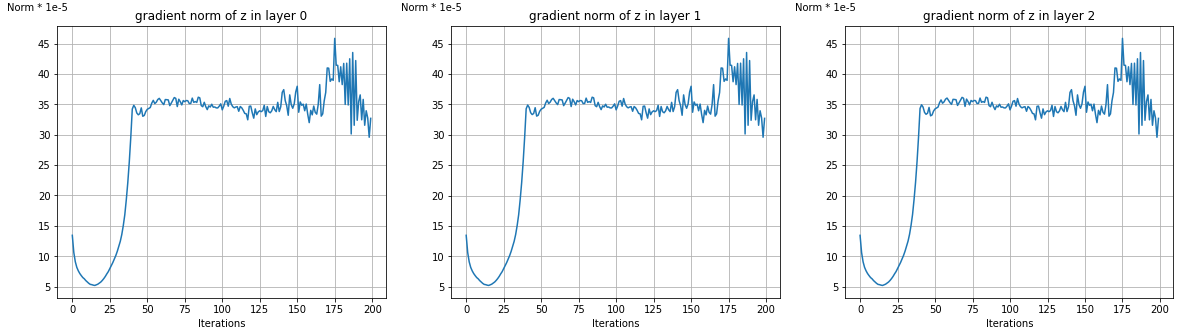

(1, 3)


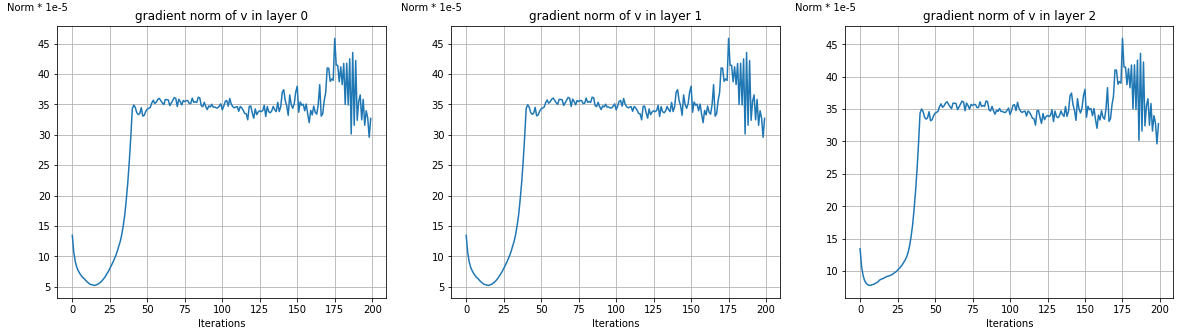

In [8]:
plot_grad_norm(grad_z_norm_dict, configs.n_layers + 1, obj="z")
plot_grad_norm(grad_v_norm_dict, configs.n_layers + 1, obj="v")

In [9]:
json_path = "./configs/NC/KarateClub/sphere.json"
configs = load_config({}, json_path)
device = torch.device("cuda:0")
data_plot = load_data(configs.root_path, configs.dataset)
if configs.manifold == "euclidean":
    manifold = Euclidean()
elif configs.manifold == 'lorentz':
    manifold = Lorentz()
elif configs.manifold == 'sphere':
    manifold = Sphere()
else:
    raise NotImplementedError
model_plot = RiemannianSpikeGNN(manifold, T=configs.T, n_layers=configs.n_layers,
                           in_dim=data_plot["num_features"], neuron=configs.neuron,
                           embed_dim=configs.embed_dim, n_classes=data_plot["num_classes"],
                           step_size=configs.step_size, v_threshold=configs.v_threshold,
                           dropout=configs.dropout, self_train=configs.self_train,
                           task=configs.task)
model_plot.load_state_dict(torch.load(f"./checkpoints/{configs.task}_{configs.dataset}_{configs.manifold}_{0}.pt"))
model_plot.eval()


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])


RiemannianSpikeGNN(
  (manifold): Sphere manifold
  (encoder): RSEncoderLayer(
    (manifold): Sphere manifold
    (fc): GCNConv(34, 3)
    (drop): Dropout(p=0.0, inplace=False)
    (drop_edge): DropEdge()
    (neuron): RiemannianIFNode(
      (manifold): Sphere manifold
    )
  )
  (layers): ModuleList(
    (0-9): 10 x RiemannianSGNNLayer(
      (manifold): Sphere manifold
      (layer): GCNConv(3, 3)
      (neuron): RiemannianIFNode(
        (manifold): Sphere manifold
      )
      (drop): Dropout(p=0.0, inplace=False)
      (drop_edge): DropEdge()
    )
  )
  (fc): Linear(in_features=3, out_features=4, bias=False)
)

In [10]:
xs= []
zs = []
vs = []
z_os = []
x_os = []
neuron_hooks = []
def neuron_forward_hook(module, input, output):
    print(module)
    print(len(input), len(output))
    xs.append(input[0])
    vs.append(input[1])
    zs.append(input[2])
    z_os.append(output[1])
    x_os.append(output[0])

for name, module in model_plot.named_modules():
    if isinstance(module, RiemannianIFNode) or isinstance(module, RiemannianLIFNode):
        neuron_hook = module.register_forward_hook(neuron_forward_hook)
        neuron_hooks.append(neuron_hook)

output = model_plot(data_plot).detach().cpu().numpy()
remove_hooks(neuron_hooks)

RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2
RiemannianIFNode(
  (manifold): Sphere manifold
)
3 2


In [11]:
def geodesic_fn(manifold, x, y, points=100):
    """
    
    :param manifold: 
    :param x: (D, )
    :param y: (D, )
    :param points: int 
    :return: 
    """
    t = torch.linspace(0, 1, points).unsqueeze(-1) # (T, )
    return manifold.geodesic(t, x.unsqueeze(0), y.unsqueeze(0))

def plot_geodesic(manifold, x: torch.Tensor, y: torch.Tensor, ax):
    points = geodesic_fn(manifold, x, y).detach().cpu().numpy()
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color='yellow', linewidth=1.5, alpha=1)
    ax.set_axis_off()

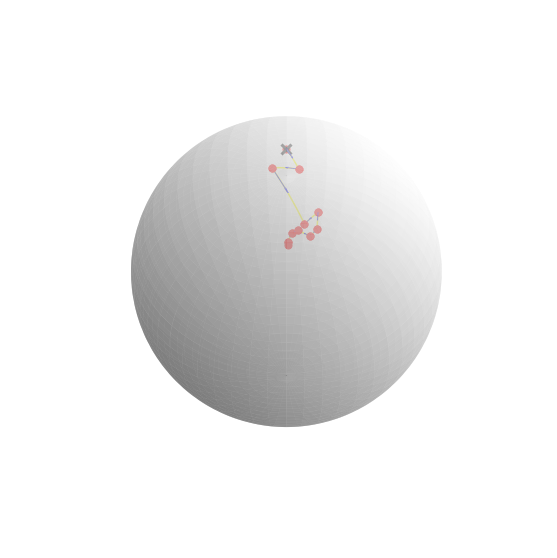

In [12]:
radius = 1

u = np.linspace(0, 2 * np.pi, 1000)
v = np.linspace(0, np.pi, 1000)

x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, color='white', alpha=0.5)
ax.set_box_aspect([1, 1, 1]) 

elev = -50  # 可以调整为其他仰俯角度
azim = 180  # 将方位角设置为180度，这样z轴的方向就反过来了
ax.view_init(elev, azim)

ax.set_xlim([-radius, radius])
ax.set_ylim([-radius, radius])
ax.set_zlim([-radius, radius])

node = 7
for i in range(len(zs) - 1):
    tv = vs[i][node].detach().cpu().numpy() * 0.5
    tv_1 = vs[i+1][node].detach().cpu().numpy() * 0.5
    p = zs[i][node]
    p_1 = zs[i+1][node]
    plot_geodesic(manifold, p, p_1, ax)
    p = p.detach().cpu().numpy()
    p_1 = p_1.detach().cpu().numpy()
    ax.quiver(p[0], p[1], p[2], tv[0], tv[1], tv[2], length=1, arrow_length_ratio=0.2, color='blue', linewidth=0.8)
    ax.scatter(p[0], p[1], p[2], c='red', marker='o', s=50)
    ax.scatter(p_1[ 0], p_1[1], p_1[2], c='red', marker='o', s=50)
    
# output = output.detach().cpu().numpy()
ax.scatter(output[0, 0], output[0, 1], output[0, 2], c='red', marker='o', s=50)
ax.scatter(-1., 0., 0., c='black', marker='x', s=100, linewidths=3.)
ax.set_axis_off()
plt.savefig(f"./pics/manifold_{node}.pdf", transparent=True, bbox_inches='tight', dpi=500)
plt.show()

In [13]:
dataset = "computers"
manifolds = ["lorentz", "sphere", "euclidean"]
path_my = f"./results/times/backward_time_{dataset}_True_"
path = f"./results/times/backward_time_{dataset}_False_"
latency = [30, 50, 70, 100]
back_times_IF_my = {m: {k: np.load(path_my + f"{m}_" + f"{k}.npy") for k in latency} for m in manifolds}
back_times_IF = {m: {k: np.load(path + f"{m}_" + f"{k}.npy") for k in latency} for m in manifolds}
results_IF_my_mean = {m: np.array([np.mean(back_times_IF_my[m][k]) for k in latency]) for m in manifolds}
# results_IF_my_std = np.array([np.std(back_times_IF_my[k]) for k in latency])
results_IF_mean = {m: np.array([np.mean(back_times_IF[m][k]) for k in latency]) for m in manifolds}
# results_IF_std = np.array([np.std(back_times_IF[k]) for k in latency])


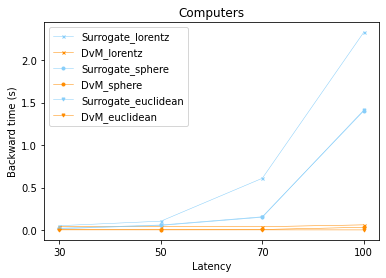

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
n = len(latency)
markers = {"lorentz": "x", "sphere": "o", "euclidean": "v"}
for m in manifolds:
    ax.plot(np.arange(n), results_IF_mean[m], c="lightskyblue", label=f"Surrogate_{m}", marker=markers[m], linewidth=0.5, markersize=3.)
    ax.plot(np.arange(n), results_IF_my_mean[m], c="darkorange", label=f"DvM_{m}", marker=markers[m], linewidth=0.5, markersize=3.)
x_ticks = ax.set_xticks(np.arange(n))
x_labels = ax.set_xticklabels([str(k) for k in latency])
ax.set_xlabel("Latency")
ax.set_title("Computers")
y_label = ax.set_ylabel("Backward time (s)", rotation=90)
x, y = y_label.get_position()   
# y_label.set_position((x, y + 0.55))
legend = ax.legend()
plt.savefig("./pics/times.pdf")